# Redes Neuronales
 
Las redes neuronales son uno de los modelos más usados por su versatilidad y gran rendimiento, sin embargo son de los modelos más complejos, con muchos parámetros que se deben calcular por lo que requieren de mucho tiempo y poder de cómputo para su entrenamiento. De hecho, los algoritmos en los que se basan las redes neuronales no son nuevos, sin embargo, el auge de las mismas es mucho más reciente debido de que ahora se posee suficiente poder de cómputo como para entrenar a las redes neuronales. 
 
Para el entrenamiento de las redes neuronales no se usa el CPU, en su lugar usamos el GPU, estos son los procesadores de tarjetas gráficas, esto se debe a que, por su estructura, tienen una capacidad mayor para procesar más operaciones pequeñas simultáneamente. 
 
En este campo las grandes empresas de tecnología son pioneras en la investigación y desarrollo de nuevas herramientas, y, la mayoría de estas son abiertas, como lo es [PyTorch](https://pytorch.org/) de Facebook y [TensorFlow](https://www.tensorflow.org/?hl=es-419) de Google, ambos son marcos de trabajo (frameworks) especializados en redes neuronales artificiales de todo tipo.
 
# PyTorch
 
PyTorch es un framework desarrollado por Facebook para el procesamiento de redes neuronales artificiales, se basa en la creación de tensores los cuales son similares en estructura y capacidad a los array de numpy, sin embargo estos tienen algunas características adicionales, como el procesamiento en GPU y otras propiedades que facilitan la implementación del algoritmo de _Backpropagation_. 
 
Para poder usar GPU en Colab debemos activarlo primero, para esto debemos abrir el menú _Entorno de ejecución_ y seleccionar _Cambiar tipo de entorno de ejcución_, en la opción _acelerador de software_ colocar GPU y hacer clic en Guardar. 
 
En este ejemplo vamos a implementar una red neuronal para predecir precios de inmuebles usando uno de los datos pre cargados de scikit-learn. Este conjunto contiene información de diferentes barrios de la ciudad de Boston, con información agregada sobre la población en esos barrios, adicionalmente se cuenta con la información del precio promedio de las viviendas en el barrio, el cual es nuestra variable objetivo.  

In [ ]:
from sklearn.datasets import load_boston
import numpy as np

boston = load_boston()
print(boston.feature_names)
prices = np.expand_dims(boston['target'], axis=1).astype(np.float32)
boston = boston.data.astype(np.float32)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Como en todo proyecto de ML lo primero que debemos hacer es dividir los datos en entrenamiento y prueba. 

In [ ]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(boston, prices, test_size=0.3, random_state=1)

A continuación definiremos la arquitectura de la red a utilizar, cuantas capas se van a colocar y cuantas neuronas tendrá cada capa. Lamentablemente no existe una "receta" para definir estos parámetros, lo que se aconseja es buscar algún estudio previo sobre el campo en el que se va a trabajar para ver qué estructura se ha usado antes y partir de allí. 
 
En este caso vamos a entrenar un perceptrón multicapa, con dos capas ocultas, cuya función de activación será una ReLu, más la capa de salida que tendrá una función de activación lineal, definiremos la arquitectura base parametrizando la cantidad de neuronas en cada capa, de forma que se puedan realizar múltiples pruebas hasta encontrar el número de neuronas más eficiente. 

In [ ]:
# Importamos varias instancias de pytorch a diferentes niveles para facilitar el llamado de las funciones.  
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Definimos la red neuronal, esto lo hacemos como si se definiera una clase.
# Colocamos como parámetro nn.module para que esta clase herede todas las funcionalidades de la clase nn.Module
class Net(nn.Module):
    # Definimos la función de instanciación de la clase, esta función es ejecutada cuando se crea una instancia de la clase. 
    def __init__(self, data_features, hidden_neurons, output_size):
        super(Net, self).__init__()
        # En esta sección se crea la estructura de la red, seran dos capas ocultas más la capa de salida. 
        self.hidden1 = nn.Linear(data_features, hidden_neurons)
        self.hidden2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.out = nn.Linear(hidden_neurons, output_size)

    # Este método es necesario para el entrenamiento, lo que hace es evaluar la salida de la red con los datos x
    # Notar que las funciones de activación se colocan en esta etapa. 
    def forward(self, x):
        x = F.relu(self.hidden1(x)) 
        x = F.relu(self.hidden2(x))     
        return self.out(x)

Para el entrenamiento haremos una de las versiones más comunes de _backpropagation_ conocida como _minibatch_,. Esta versión modifica los parámetros del modelo tras procesar una cantidad pequeña de datos, de esta forma se acelera el proceso de entrenamiento, a cambio de agregar un hyper parámetro al modelo: la cantidad de datos a procesar antes de modificar los parámetros de la red. 
 
El entrenamiento de las redes se realiza a través de épocas. Una época se define como cada vez que todos los datos de entrenamiento son vistos por el modelo, luego, debemos decidir cuántas iteraciones dejaremos que realice el algoritmo de entrenamiento.
 
Otro hyper parámetro a seleccionar es la tasa de aprendizaje o learning rate, este valor define la rapidez con la que el algoritmo intentará acercarse al punto óptimo Un valor muy chico hará que el algoritmo sea muy lento y tarde en llegar  al valor óptimo. Un valor muy grande puede hacer que el algoritmo no consiga un valor óptimo. 

![Learning Decay Rate](http://cs231n.github.io/assets/nn3/learningrates.jpeg?w=640)
 
En nuestro ejemplo tenemos 13 variables en los datos de entrada, y las capas ocultas tendrán 100 neuronas cada una. 


In [ ]:
# Tamaño del batch de entrenamiento
batch_size = 50

# Número de épocas
num_epochs = 5000

# Tasa de aprendizaje 
learning_rate = 0.00001

# Creamos nuestra red, la cual tiene 13 variable sde entrada, y 100 neuronas en las capas ocultas
# Como es un problema de regresión la capa de salida debe de tener solo una neurona.
net = Net(13 ,100 ,1)

Luego debemos definir algunas otras cosas propias del framework, como lo son:
* **La función de pérdida a usar**. Esta es la métrica usada para evaluar el desempeño de la red, en este caso usaremos el error cuadrático medio como función de pérdida.  
* **El optimizador**. Es la metodología a usar para minimizar la función de pérdida.
* **Dataset**. estos son los datos con los que se entrenaran las redes pero convertidos en tensores. 
* **DataLoader**. Este objeto facilita el suministro de datos a la red en función de los _minibatches_ definidos. 

In [ ]:
# Función de perdida
loss_function = nn.MSELoss()

# Optimizador
optimizer = torch.optim.Adam(net.parameters() , lr=learning_rate)

# Datos convertidos en tensores
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())

# Objeto auxiliar para facilitar el suministro de datos
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# En esta lista mantendremos registro del valor de la función de perdida para ver su evolución
loss_list = []

Finalmente entrenamos nuestra red neuronal artificial. 
 
Como sabemos este es un proceso iterativo basado en el número de épocas previamente definidas, por lo que el uso de un ”_for_” es natural. Luego se itera por los _minibatches_ formados por el dataloader.
 
En cada _minibatch_ se realiza lo que denominamos la pasada _forward_ o hacia adelante, la cual es la evaluación de la red con los datos del _minibatch_. Luego en la pasada _backward_ o hacia atrás, se actualizan los parámetros de la red. 
 
Por último guardamos el valor de la función de pérdida e imprimimos el estado del entrenamiento cada 100 épocas. 

In [ ]:
# Bucle de entrenamiento
for i in range(num_epochs):

    # Iteramos sobre todos los minibatches
    for x, y in loader:
        
        # Pasada forward
        optimizer.zero_grad()
        loss = loss_function(net(x), y)  
        
        # Pasada backward         
        loss.backward()
        
        # Se actualizan los pesos de la red
        optimizer.step()
        loss_list.append(loss.data.item())

    # Mostramos el estado del entrenamiento cada 100 epcocas       
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, loss))

Epoch 100, loss = 27.3764
Epoch 200, loss = 40.4098
Epoch 300, loss = 81.4497
Epoch 400, loss = 175.016
Epoch 500, loss = 9.27248
Epoch 600, loss = 230.434
Epoch 700, loss = 68.7615
Epoch 800, loss = 39.0757
Epoch 900, loss = 41.9607
Epoch 1000, loss = 14.037
Epoch 1100, loss = 9.41991
Epoch 1200, loss = 79.5394
Epoch 1300, loss = 19.9151
Epoch 1400, loss = 35.3241
Epoch 1500, loss = 81.5444
Epoch 1600, loss = 24.7592
Epoch 1700, loss = 2.83331
Epoch 1800, loss = 19.7417
Epoch 1900, loss = 17.6709
Epoch 2000, loss = 14.4349
Epoch 2100, loss = 8.02654
Epoch 2200, loss = 10.807
Epoch 2300, loss = 45.0713
Epoch 2400, loss = 167.647
Epoch 2500, loss = 3.22181
Epoch 2600, loss = 18.7374
Epoch 2700, loss = 16.234
Epoch 2800, loss = 64.1794
Epoch 2900, loss = 7.89524
Epoch 3000, loss = 9.38609
Epoch 3100, loss = 22.1742
Epoch 3200, loss = 8.36633
Epoch 3300, loss = 11.1566
Epoch 3400, loss = 30.8305
Epoch 3500, loss = 36.9436
Epoch 3600, loss = 19.9957
Epoch 3700, loss = 5.00431
Epoch 3800, l

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

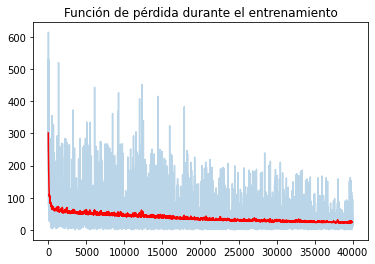

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

Podemos ver como la función de pérdida tiende a disminuir hasta que a partir de un punto se mantiene estable. Esto quiere decir que ya se alcanzó el valor mínimo de la función de pérdida. 

## Ejercicios:
 
1. Complete el código para evaluar el desempeño de la red neuronal. 
2. Cambie la estructura de la red neuronal y mide como varía el desempeño y tiempo de entrenamiento.

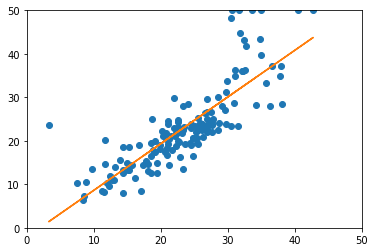

In [ ]:
from sklearn.linear_model import LinearRegression

pred = net(torch.FloatTensor(X_test)).detach().numpy()
plt.plot(pred, ____, 'o')
plt.ylim((0,50))
plt.xlim((0,50))
X, Y = pred.reshape(-1,1), y_test.reshape(-1,1)
plt.plot( X, LinearRegression().____(X, Y).predict(___))

## Redes convolucionales
 
Con pytorch podemos trabajar tanto perceptrones multicapa como redes convolucionales y otros tipos de redes.
 
Lo único que debemos cambiar en la estructura es, en lugar de agregar capas lineales agregar capas convolucionales. Veamos un ejemplo clásico con el dataset mnist, el cual consiste de números escritos a mano, y lo que se busca es entrenar una red en el que se identifiquen correctamente estos dígitos. 
 
Lo primero que debemos hacer es cargar los datos, que en este caso ya se encuentran divididos en entrenamiento y prueba.


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


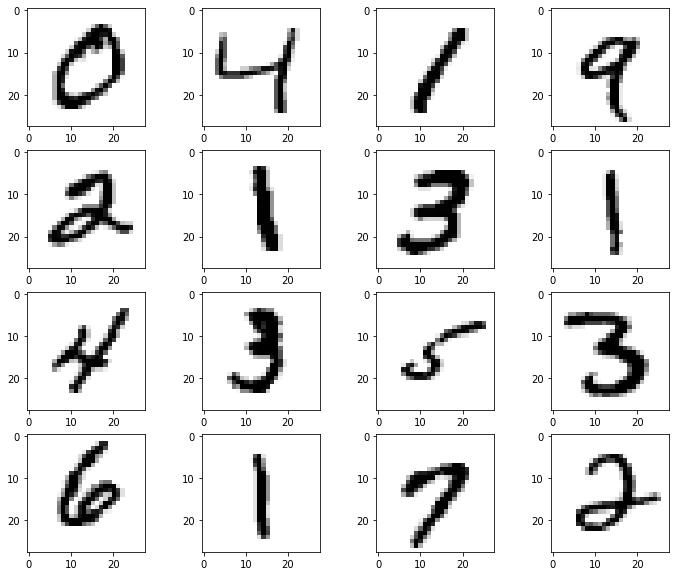

In [ ]:
# Esta celda puede tardar unos minutos.

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [("User-agent", "Mozilla/5.0")]
urllib.request.install_opener(opener)

plt.rcParams['figure.figsize'] = [12, 10]

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())


for i in range(1,17):
    plt.subplot(4,4,i)
    plt.imshow(mnist_train.train_data[i,:,:], cmap=plt.get_cmap('gray_r'))

Luego definimos la arquitectura de la red, en este caso serán dos capas convolucionales, ambas seguidas de capas de max pooling (reducción de dimensionalidad), finalmente conectaremos un perceptrón multicapa para realizar la clasificación.  

In [ ]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3, padding = 1)
        self.conv2 = nn.Conv2d(6,16,3, padding = 1)
        self.fc1 = nn.Linear(784,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        # Pasamos de red convolucional a perceptron multicapa.
        x = x.view(x.size()[0], 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Luego entrenamos la red de la misma forma que en el ejercicio anterior.

Epoch 10, loss = 0.18504
Epoch 20, loss = 0.0682434
Epoch 30, loss = 0.00250352
Epoch 40, loss = 0.0234465


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

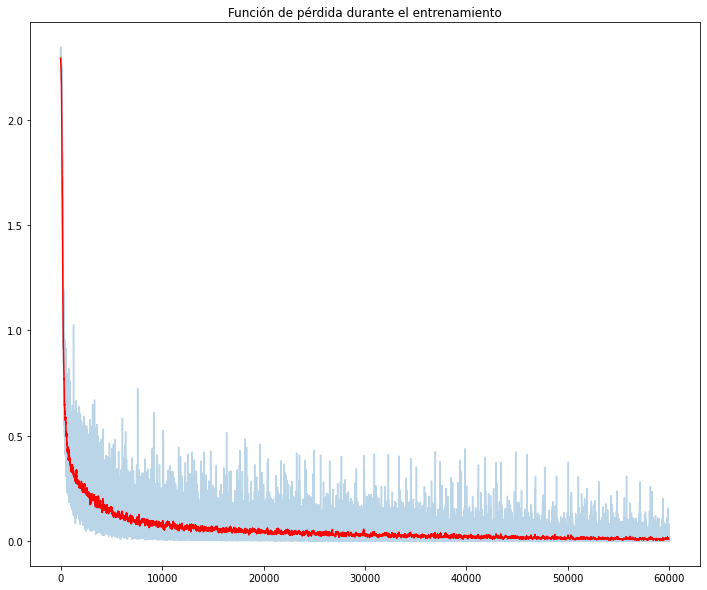

In [ ]:
# establecemos los hiper parametros de entrenamiento

batch_size = 50
learning_rate = 0.0001
num_epochs = 50

# definimos el uso de GPU en lugar de CPU
device = torch.device('cuda:0')

# Inicializamos la red
net = NetCNN()
net.to(device)

# Optimizador
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss() 

# Objetos auxiliares
loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True)
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):
    for x, y in loader:
        
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)

        loss = criterion(net(x), y)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.data.item())

    if i > 0 and i % 10 == 0:
      print('Epoch %d, loss = %g' % (i, loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")
